In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
from __future__ import annotations

class Value():
    def __init__(self, data: int | float, children = (), op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other: Value | int | float):
        addend = other if isinstance(other, Value) else Value(other, label=f'{other}')
        out = Value(self.data + addend.data, (self, addend), '+', label='R_+')

        def _backward():
            self.grad += 1.0 * out.grad
            addend.grad += 1.0 * out.grad

        self._backward = _backward
        
        return out

    def __mul__(self, other: Value | int | float):
        multiplier = other if isinstance(other, Value) else Value(other, label=f'{other}')
        out = Value(self.data * multiplier.data, (self, multiplier), '*', label='R_*')
        
        def _backward(): 
            self.grad += multiplier.data * out.grad
            multiplier.grad += self.data * out.grad

        self._backward = _backward
            
        return out

    def __truediv__(self, other: Value | int | float):
        other = other if isinstance(other, Value) else Value(other, label=f'{other}')
        denominator = other.data

        out = Value(self.data * denominator ** -1, (self, denominator), label='R_/')

    def tanh(self):
        t = (math.exp(self.data * 2) - 1) / (math.exp(self.data * 2) + 1)
        out = Value(t, (self, ), 'tanh', label='R_tanh')

        def _backward():
            self.grad = 1 - t ** 2 * out.grad

        self._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for c in v._prev:
                    build_topo(c)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()


a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(5.0, label='c')
L = (a + 1.0) * b + c; L.label = 'L'

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

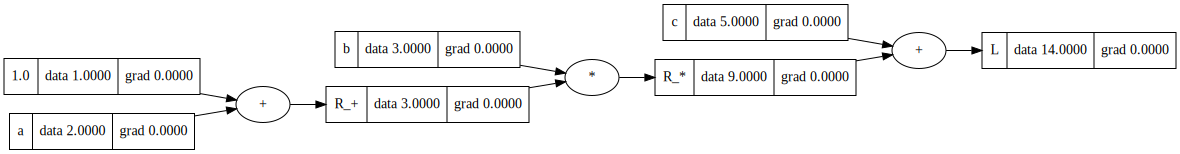

In [15]:
draw_dot(L)

In [42]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(3.0, label='b')
    c = Value(5.0, label='c')
    L = (a + 1.0) * b + c; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(3.0, label='b')
    c = Value(5.0, label='c')
    L = (a + 1.0) * b + c; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

3.0000000000001137


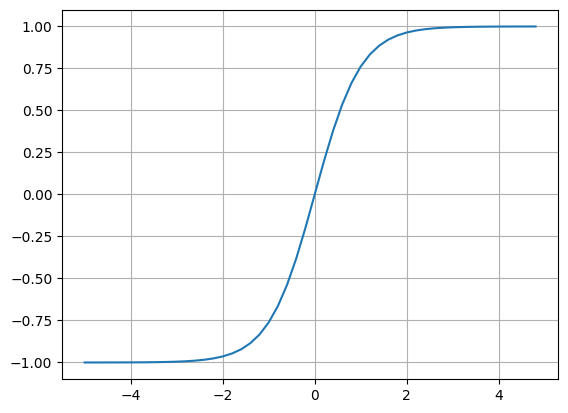

In [19]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [64]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [66]:
o.backward()

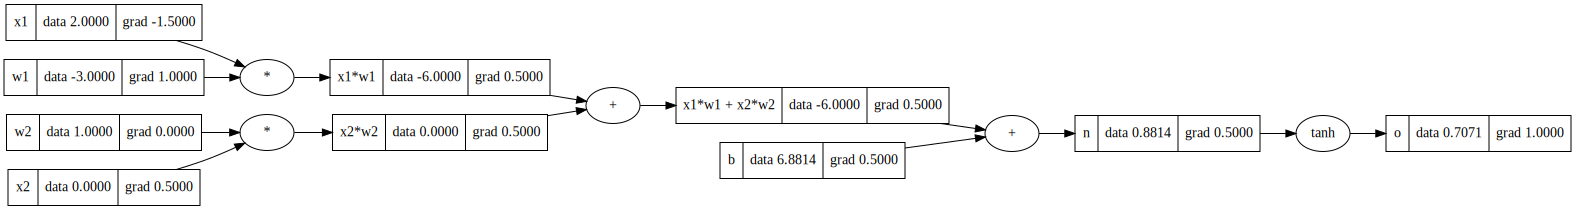

In [67]:
draw_dot(o)